# Natural Language Processing - Knowledge Graph example

###### Links: [Dataset (Wikipedia page: History of Rome)](https://en.wikipedia.org/wiki/History_of_Rome)  |  [Article (TowardsDataScience)]()

### 0 - Setup

###### Import pckgs

In [409]:
import warnings
warnings.filterwarnings("ignore")

## for data
import pandas as pd  #1.1.5
import numpy as np  #1.21.0

## for plotting
import matplotlib.pyplot as plt  #3.3.2
import seaborn as sns  #0.11.1

## for text
import wikipediaapi  #0.5.8
import nltk  #3.8.1
import re   
import contractions  #0.1.73

## for nlp
import spacy  #3.5.0
from spacy import displacy
import textacy  #0.12.0

## for graph
import networkx as nx  #3.0 (also pygraphviz==1.10)
import plotly.graph_objs as go  #5.1.0

## for timeline
import dateparser #1.1.7

###### Import data

In [109]:
topic = "Russo-Ukrainian War"

wiki = wikipediaapi.Wikipedia('en')
page = wiki.page(topic)
txt = page.text[:page.text.find("See also")]
txt[0:500] + " ..."

"The Russo-Ukrainian War is an ongoing international conflict between Russia, alongside Russian-backed separatists, and Ukraine, which began in February 2014. Following Ukraine's Revolution of Dignity, Russia annexed Crimea from Ukraine and supported pro-Russian separatists fighting the Ukrainian military in the Donbas war. The first eight years of conflict also included naval incidents, cyberwarfare, and heightened political tensions. In February 2022, Russia launched a full-scale invasion of Uk ..."

In [110]:
'''
Compute n-grams frequency with nltk tokenizer.
:parameter
    :param txt: text
    :param ngrams: int or list - 1 for unigrams, 2 for bigrams, [1,2] for both
    :param top: num - plot the top frequent words
:return
    dtf_count: dtf with word frequency
'''
def word_freq(txt, ngrams=[1,2,3], top=10, figsize=(10,7)):
    lst_tokens = nltk.tokenize.word_tokenize(txt)
    ngrams = [ngrams] if type(ngrams) is int else ngrams
    
    ## calculate
    dtf_freq = pd.DataFrame()
    for n in ngrams:
        dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, n))
        dtf_n = pd.DataFrame(dic_words_freq.most_common(), columns=["word","freq"])
        dtf_n["ngrams"] = n
        dtf_freq = dtf_freq.append(dtf_n)
    dtf_freq["word"] = dtf_freq["word"].apply(lambda x: " ".join(string for string in x) )
    dtf_freq = dtf_freq.sort_values(["ngrams","freq"], ascending=[True,False])
    
    ## plot
    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(x="freq", y="word", hue="ngrams", dodge=False, ax=ax,
                data=dtf_freq.groupby('ngrams')["ngrams","freq","word"].head(top))
    ax.set(xlabel=None, ylabel=None, title="Most frequent words")
    ax.grid(axis="x")
    plt.show()
    return dtf_freq

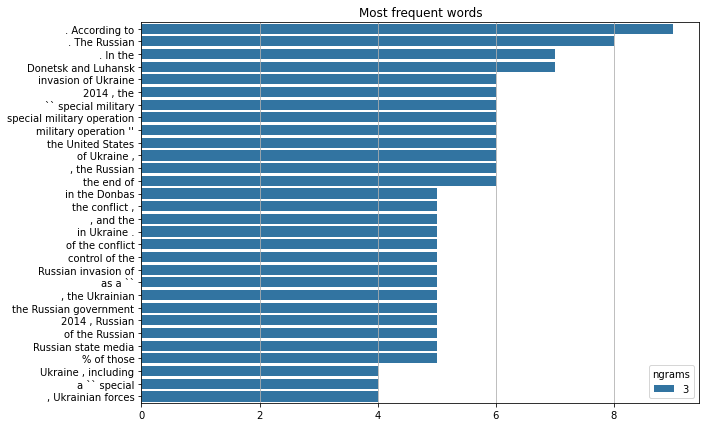

In [111]:
# Find most common words in text
_ = word_freq(txt, ngrams=[3], top=30, figsize=(10,7))

### 1 - NLP

###### Model

In [112]:
#python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")
doc = nlp(txt)

###### Sentence Segmentation

In [113]:
lst_docs = [sent for sent in doc.sents]
print("tot sentences:", len(lst_docs))

i = 3
lst_docs[i]

tot sentences: 367


In February 2022, Russia launched a full-scale invasion of Ukraine.

In [114]:
#for v,m in enumerate(lst_docs):
#    print(m, "\n----", v)

###### POS / DEP

In [115]:
print(lst_docs[i], "\n---")

for token in lst_docs[i]:
    print(token.text, "-->", "pos: "+token.pos_, "|", "dep: "+token.dep_, "")

In February 2022, Russia launched a full-scale invasion of Ukraine.
 
---
In --> pos: ADP | dep: prep 
February --> pos: PROPN | dep: pobj 
2022 --> pos: NUM | dep: nummod 
, --> pos: PUNCT | dep: punct 
Russia --> pos: PROPN | dep: nsubj 
launched --> pos: VERB | dep: ROOT 
a --> pos: DET | dep: det 
full --> pos: ADJ | dep: amod 
- --> pos: PUNCT | dep: punct 
scale --> pos: NOUN | dep: compound 
invasion --> pos: NOUN | dep: dobj 
of --> pos: ADP | dep: prep 
Ukraine --> pos: PROPN | dep: pobj 
. --> pos: PUNCT | dep: punct 

 --> pos: SPACE | dep: dep 


In [116]:
displacy.render(lst_docs[i], style="dep", options={"distance":100})

###### NER

In [120]:
for tag in lst_docs[i].ents:
    print(tag.text, f"({tag.label_})") 

February 2022 (DATE)
Russia (GPE)
Ukraine (GPE)


In [121]:
displacy.render(lst_docs[i], style="ent")

### 2 - Entities, Relations, Attributes

###### Entities Extraction

In [124]:
## Using POS/DEP
def extract_entities(doc):
    a, b, prev_dep, prev_txt, prefix, modifier = "", "", "", "", "", ""
    for token in doc:
        if token.dep_ != "punct":
            ## prexif --> prev_compound () + compound ()
            if token.dep_ == "compound":
                prefix = prev_txt +" "+ token.text if prev_dep == "compound" else token.text
            
            ## modifier --> prev_compound () + %mod ()
            if token.dep_.endswith("mod") == True:
                modifier = prev_txt +" "+ token.text if prev_dep == "compound" else token.text
            
            ## subject --> modifier () + prefix () + %subj ()
            if token.dep_.find("subj") == True:
                a = modifier +" "+ prefix + " "+ token.text
                prefix, modifier, prev_dep, prev_txt = "", "", "", ""
            
            ## if object --> modifier () + prefix () + %obj ()
            if token.dep_.find("obj") == True:
                b = modifier +" "+ prefix +" "+ token.text
            
            prev_dep, prev_txt = token.dep_, token.text
    
    # clean
    a = " ".join([i for i in a.split()])
    b = " ".join([i for i in b.split()])
    return (a.strip(), b.strip())

In [125]:
lst_entities = [extract_entities(i) for i in lst_docs]
lst_entities[i]

('2022 Russia', 'full scale Ukraine')

###### Relation Extraction

In [126]:
## Using Matcher
def extract_relation(doc, nlp):
    matcher = spacy.matcher.Matcher(nlp.vocab)
    p1 = [{'DEP':'ROOT'}, 
          {'DEP':'prep', 'OP':"?"},
          {'DEP':'agent', 'OP':"?"},
          {'POS':'ADJ', 'OP':"?"}] 
    matcher.add(key="matching_1", patterns=[p1]) 
    matches = matcher(doc)
    k = len(matches) - 1
    span = doc[matches[k][1]:matches[k][2]] 
    return span.text

In [127]:
lst_relations = [extract_relation(i,nlp) for i in lst_docs]
lst_relations[i]

'launched'

###### Attribute Extraction

In [128]:
## Using NER
lst_attr = []
for x in lst_docs:
    attr = ""
    for tag in x.ents:
        attr = attr+tag.text if tag.label_=="DATE" else attr+""
    lst_attr.append(attr)

lst_attr[i]

'February 2022'

###### Summary

In [129]:
dtf = pd.DataFrame({"text":[doc.text for doc in lst_docs],
                    "entity":[i[0] for i in lst_entities],
                    "relation":lst_relations,
                    "object":[i[1] for i in lst_entities],
                    "attribute":lst_attr
                   })
dtf.head(3)

text        entity  \
0  The Russo-Ukrainian War is an ongoing internat...  backed which   
1  Following Ukraine's Revolution of Dignity, Rus...        Russia   
2  The first eight years of conflict also include...   eight years   

         relation                object              attribute  
0              is              February          February 2014  
1         annexed  Ukrainian Donbas war                         
2  included naval       naval incidents  The first eight years

### 3 - Textacy

###### Entities and Relations

In [430]:
dic = {"id":[], "text":[], "entity":[], "relation":[], "object":[]}

for n,sentence in enumerate(lst_docs):
    lst_generators = list(textacy.extract.subject_verb_object_triples(sentence))  
    for sent in lst_generators:
        subj = "_".join(map(str, sent.subject))
        obj  = "_".join(map(str, sent.object))
        relation = "_".join(map(str, sent.verb))
        dic["id"].append(n)
        dic["text"].append(sentence.text)
        dic["entity"].append(subj)
        dic["object"].append(obj)
        dic["relation"].append(relation)

dtf = pd.DataFrame(dic)
dtf[dtf["id"]==i]

id                                               text  entity  relation  \
3   3  In February 2022, Russia launched a full-scale...  Russia  launched   

           object  
3  scale_invasion

In [433]:
dtf = dtf[dtf["object"].str.len() < 20]

###### Attributes

In [434]:
## Date
attribute = "date"
dic = {"id":[], "text":[], attribute:[]}

for n,sentence in enumerate(lst_docs):
    lst = list(textacy.extract.entities(sentence, include_types={"DATE"}))
    if len(lst) > 0:
        for attr in lst:
            dic["id"].append(n)
            dic["text"].append(sentence.text)
            dic[attribute].append(str(attr))
    else:
        dic["id"].append(n)
        dic["text"].append(sentence.text)
        dic[attribute].append(np.nan)

dtf_att = pd.DataFrame(dic)
dtf_att = dtf_att[~dtf_att[attribute].isna()]
dtf_att[dtf_att["id"]==i]

id                                               text           date
3   3  In February 2022, Russia launched a full-scale...  February 2022

In [435]:
## Location
attribute = "location"
dic = {"id":[], "text":[], attribute:[]}

for n,sentence in enumerate(lst_docs):
    lst = list(textacy.extract.entities(sentence, include_types={"LOC","GPE"}))
    if len(lst) > 0:
        for attr in lst:
            dic["id"].append(n)
            dic["text"].append(sentence.text)
            dic[attribute].append(str(attr))
    else:
        dic["id"].append(n)
        dic["text"].append(sentence.text)
        dic[attribute].append(np.nan)

dtf_att_2 = pd.DataFrame(dic)
dtf_att_2 = dtf_att_2[~dtf_att_2[attribute].isna()]

dtf_att_2[dtf_att_2["id"]==i]

id                                               text location
8   3  In February 2022, Russia launched a full-scale...   Russia
9   3  In February 2022, Russia launched a full-scale...  Ukraine

###### Summary

### 4 - Network Graph

###### Networkx

In [380]:
## full
G = nx.from_pandas_edgelist(dtf, source="entity", target="object", edge_attr="relation", create_using=nx.DiGraph())

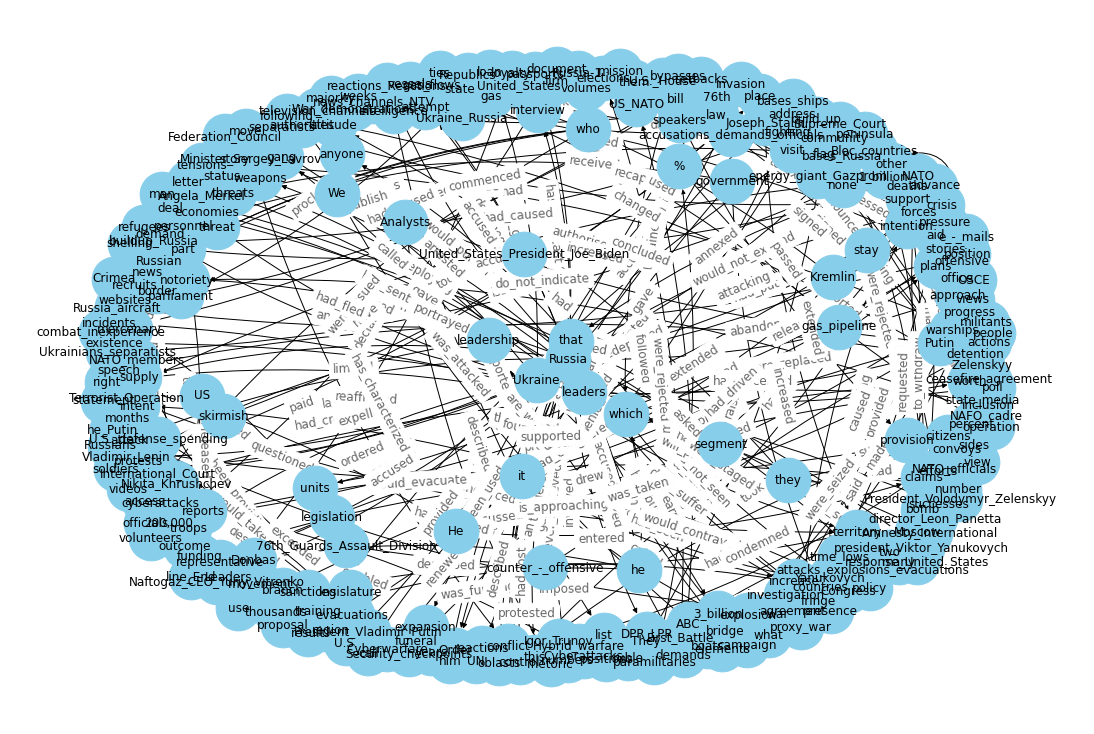

In [381]:
plt.figure(figsize=(15,10))

#pos = nx.nx_agraph.graphviz_layout(G, prog="fdp")
pos = nx.spring_layout(G, k=1)

node_color = "skyblue"
edge_color = "black"

nx.draw(G, pos=pos, with_labels=True, node_color=node_color, edge_color=edge_color, cmap=plt.cm.Dark2, 
        node_size=2000, connectionstyle='arc3,rad=0.1')

nx.draw_networkx_edge_labels(G, pos=pos, label_pos=0.5, edge_labels=nx.get_edge_attributes(G,'relation'),
                             font_size=12, font_color='black', alpha=0.6)
plt.show()

In [382]:
## top
dtf["entity"].value_counts().head()

Russia     25
it          9
they        8
Ukraine     7
Putin       7
Name: entity, dtype: int64

In [383]:
## filter
f = "Russia"
tmp = dtf[(dtf["entity"]==f) | (dtf["object"]==f)]

G = nx.from_pandas_edgelist(tmp, source="entity", target="object", edge_attr="relation", create_using=nx.DiGraph())

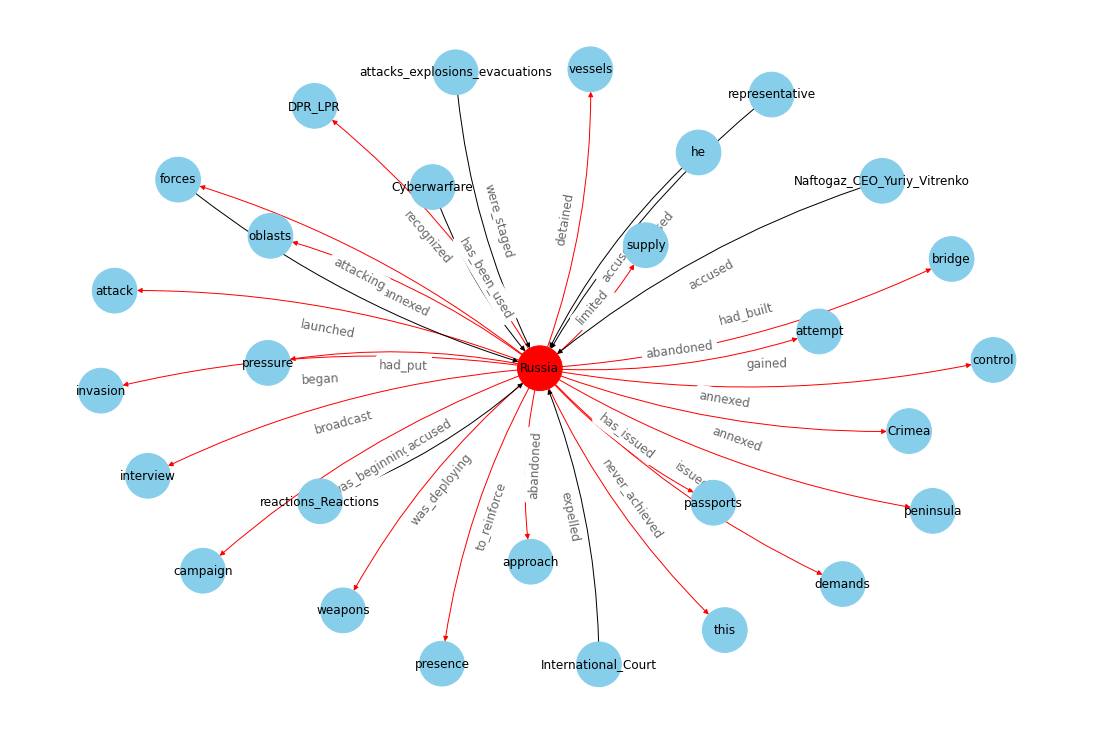

In [390]:
plt.figure(figsize=(15,10))

pos = nx.nx_agraph.graphviz_layout(G, prog="neato")
#pos = nx.spring_layout(G, k=2.5)

node_color = ["red" if node==f else "skyblue" for node in G.nodes]
edge_color = ["red" if edge[0]==f else "black" for edge in G.edges]

nx.draw(G, pos=pos, with_labels=True, node_color=node_color, edge_color=edge_color, cmap=plt.cm.Dark2, 
        node_size=2000, node_shape="o", connectionstyle='arc3,rad=0.1')

nx.draw_networkx_edge_labels(G, pos=pos, label_pos=0.5, edge_labels=nx.get_edge_attributes(G,'relation'),
                             font_size=12, font_color='black', alpha=0.6)
plt.show()

###### Plotly

In [219]:
## setup
pos = nx.spring_layout(G, k=0.2)
for n,p in pos.items():
    G.nodes[n]['pos'] = p
    
## links
edge_x, edge_y = [], []
arrows = []
for n,edge in enumerate(G.edges()):
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)
    arrows.append([[x0,y0],[x1,y1]])

edge_trace = go.Scatter(x=edge_x, y=edge_y, mode='lines', showlegend=False)

## nodes
node_x, node_y = [], []
for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(x=node_x, y=node_y, mode='markers', hoverinfo='text', showlegend=False,
                        marker={"showscale":False, "colorscale":'YlGnBu', "reversescale":True, 
                                "size":10, "line_width":2})

## add details
link_text, node_text, node_color, node_size = [], [], [], []
for adjacencies in G.adjacency():
    node_text.append(adjacencies[0])
    for dic in adjacencies[1].values():
        link_text.append(dic["relation"])

node_trace.text = node_text
edge_trace.text = link_text

## layout
fig = go.Figure(data=[edge_trace, node_trace])
fig.update_layout(title=topic, showlegend=True, plot_bgcolor='white', 
                  hovermode='closest', width=800, height=800,
                  xaxis={"visible":False}, yaxis={"visible":False})

fig.show()

In [220]:
## setup
pos = nx.spring_layout(G, k=0.3)
for n,p in pos.items():
    G.nodes[n]['pos'] = p
    
## links
edge_x, edge_y = [], []
edge_color, edge_size = [], []
arrows = []
for n,edge in enumerate(G.edges()):
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)
    #edge_color.append(colors[data[cat].iloc[n]])
    #edge_size.append(data[value].iloc[n])
    arrows.append([[x0,y0],[x1,y1]])

edge_trace = go.Scatter(x=edge_x, y=edge_y, mode='lines', showlegend=False)

## nodes
node_x, node_y = [], []
for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(x=node_x, y=node_y, mode='markers', hoverinfo='text', showlegend=False,
                        marker={"showscale":False, "colorscale":'YlGnBu', "reversescale":True, 
                                "size":10, "line_width":2})

## add node details
node_text, node_color, node_size = [], [], []
for node, adjacencies in enumerate(G.adjacency()):
    ### node text = company name
    node_text.append(adjacencies[0])  
    ### node color = how many links
    node_color.append(len(adjacencies[1]))
    ### node size = how much cash
    cash = sum([i[value] for i in adjacencies[1].values()])
    cash = 20 if cash > 10 else (30 if cash > 20 else np.clip(a=cash, a_min=5, a_max=10))
    node_size.append(cash)

node_trace.text = node_text
node_trace.marker.color = node_color
node_trace.marker.size = node_size

## layout
fig = go.Figure(data=[edge_trace, node_trace])
fig.update_layout(title='search: {}'.format(' + '.join(lst)), showlegend=True, plot_bgcolor='white', 
                  hovermode='closest', width=800, height=800,
                  xaxis={"visible":False}, yaxis={"visible":False})

## add directions
fig.update_layout(annotations=[{"ax":i[0][0], "ay":i[0][1], "axref":'x', "ayref":'y',
                                 "x":i[1][0],  "y":i[1][1],  "xref":'x',  "yref":'y',
                                "showarrow":True, "arrowhead":4, 
                                "arrowcolor":edge_color[n]} 
                              for n,i in enumerate(arrows)])

## add legend
for k,v in colors.items():
    fig.add_trace(go.Scatter(x=[None], y=[None], mode="markers", name=k, 
                             marker={"size":7, "color":v, "symbol":'square'}))

fig.show()

NameError: name 'value' is not defined

### 5 - Timeline

###### Parse data

In [531]:
def utils_parsetime(txt):
    try:
        dt = dateparser.parse(txt).strftime('%b-%Y')
    except:
        dt = np.nan
    return dt

In [532]:
dtf_att["dt"] = dtf_att["date"].apply(lambda x: utils_parsetime(x))
dtf_att = dtf_att[~dtf_att["dt"].isna()]
dtf_att.head(3)

id                                               text  date        dt  \
82  133  The Russian government denied the skirmish too...  76th  Apr-1976   
84  133  The Russian government denied the skirmish too...  76th  Apr-1976   
83  133  The Russian government denied the skirmish too...  76th  Apr-1976   

                          y  
82  government denied Order  
84   76th was_awarded Order  
83      skirmish took place

In [533]:
tmp = dtf.copy()
tmp["y"] = tmp["entity"]+" "+tmp["relation"]+" "+tmp["object"]

dtf_att = dtf_att.merge(tmp[["id","y"]], how="left", on="id")
dtf_att.head()

In [442]:
dtf_att = dtf_att[~dtf_att["y"].isna()].sort_values("dt", ascending=True)
dtf_att.head()

id                                               text  date        dt  \
82  133  The Russian government denied the skirmish too...  76th  Apr-1976   
84  133  The Russian government denied the skirmish too...  76th  Apr-1976   
83  133  The Russian government denied the skirmish too...  76th  Apr-1976   
12   24  After the dissolution of the Soviet Union (USS...  1991  Apr-1991   
16   29  In the years after the dissolution of the USSR...  1993  Apr-1993   

                                 y  
82         government denied Order  
84          76th was_awarded Order  
83             skirmish took place  
12  Ukraine_Russia maintained ties  
16      Bloc_countries joined NATO

In [530]:
dtf_att

id                                               text          date  \
82   133  The Russian government denied the skirmish too...          76th   
84   133  The Russian government denied the skirmish too...          76th   
83   133  The Russian government denied the skirmish too...          76th   
12    24  After the dissolution of the Soviet Union (USS...          1991   
16    29  In the years after the dissolution of the USSR...          1993   
..   ...                                                ...           ...   
228  351  Notable protests first occurred in March and l...     September   
147  245  The Ukrainian offensive in the northeast succe...     September   
142  240  In the first week of the invasion, the UN repo...  24 September   
85   140  On 3 September, Poroshenko said he and Putin h...   3 September   
145  242  On 30 September, Russia annexed four oblasts o...  30 September   

           dt                               y  
82   Apr-1976         government denied Order  
84   Apr-1976          76th was_awarded Order  
83   Apr-1976             skirmish took place  
12   Apr-1991  Ukraine_Russia maintained ties  
16   Apr-1993      Bloc_countries joined NATO  
..        ...                             ...  
228  Sep-2023         thousands protested war  
147  Sep-2023   offensive recaptured majority  
142  Sep-2023       refugees had_fled Ukraine  
85   Sep-2023  he_Putin had_reached agreement  
145  Sep-2023          Russia annexed oblasts  

[175 rows x 5 columns]

###### Plot

In [528]:
dates = dtf_att["dt"].tail(50).values

names = dtf_att["y"].tail(50).values

l = [10,-10, 8,-8, 6,-6, 4,-4, 2,-2]
levels = np.tile(l, int(np.ceil(len(dates)/len(l))))[:len(dates)]

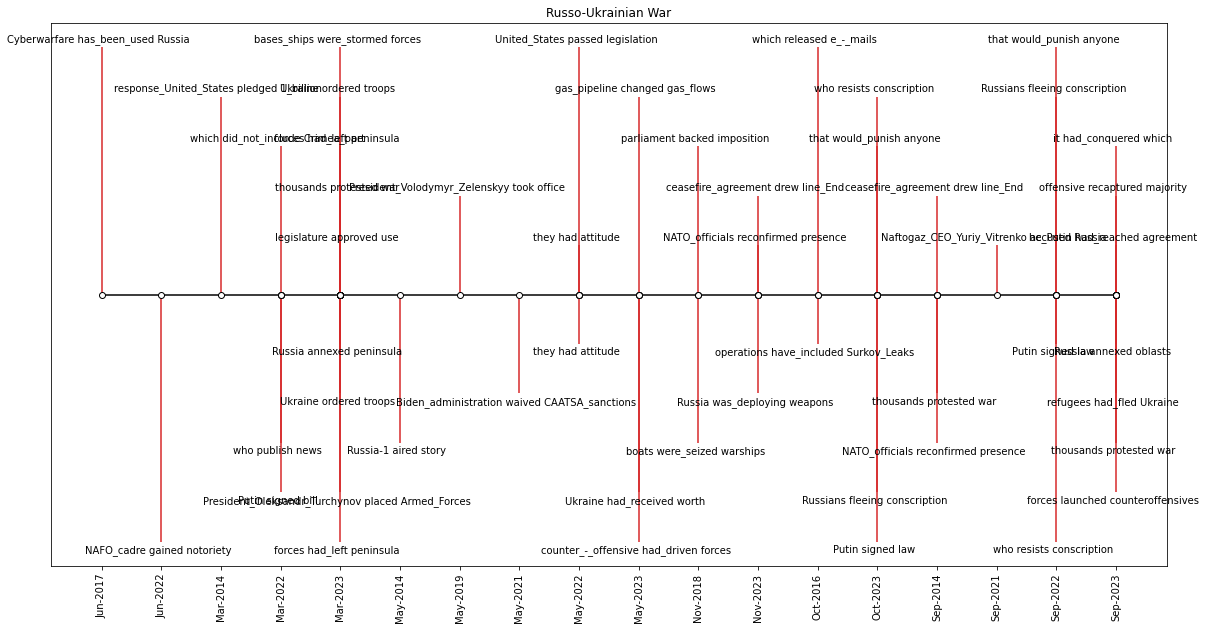

In [529]:
fig, ax = plt.subplots(figsize=(20,10))
ax.set(title=topic, yticks=[], yticklabels=[])

ax.vlines(dates, ymin=0, ymax=levels, color="tab:red")
ax.plot(dates, np.zeros_like(dates), "-o", color="k", markerfacecolor="w")

for d,l,r in zip(dates,levels,names):
    ax.annotate(r, xy=(d,l), xytext=(-3, np.sign(l)*3), textcoords="offset points",
                horizontalalignment="center",
                verticalalignment="bottom" if l>0 else "top")

plt.xticks(rotation=90) 
plt.show()

In [511]:
dtf_att[dtf_att["id"]==3]

id                                               text           date  \
1   3  In February 2022, Russia launched a full-scale...  February 2022   

         dt                               y  
1  Feb-2022  Russia launched scale_invasion